Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
This is part of a release of experimental data determined at AstraZeneca on a set of compounds in the following assays: pKa, lipophilicity (LogD7.4), aqueous solubility, plasma protein binding (human, rat, dog , mouse and guinea pig), intrinsic clearance (human liver microsomes, human and rat hepatocytes). 

## Assay Information:
During a trip through the circulatory system, a drug can bind to many different proteins within the blood plasma. This can affect a drug's efficacy - only the unbound fraction of the drug will exert pharmacological effects. Equilibrium dialysis places a semi-permeable barrier between a drug + plasma sample and a buffer, and after a certain time we measure how much drug is present in the buffer. The membrane lets the drug pass through but drugs bound to proteins are too big to pass across the membrane. Image is from [here](https://www.sciencedirect.com/science/article/abs/pii/S0079646822000029).

![image.png](https://ars.els-cdn.com/content/image/1-s2.0-S0079646822000029-f03-01-9780323989039.jpg)

## Description of readout:
- **PPB**: Percent plasma-bound. % bound to plasma by equilibrium dialysis. Compound is incubated with whole human plasma at 37C for >5hrs. Method described in B. Testa et al (Eds.), Pharmacokinetic Profiling in Drug Research: Biological, Physicochemical, and Computational Strategies, Wiley-VCH, Weinheim, 2006, pp.119-141. Experimental range 10% to 99.95% bound. Typically, the log transformation on %unbound to plasma proteins is used for machine learning. 
Interpretation of %unbound PPB in value ranges:
- good : >1
- medium: 0- 1
- bad: <0

## Data resource

**Reference**: https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/

**Raw data**: https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3301365/

## Curation reproducibility
The curation process in this notebook can be reproduced by command line:

```shell
auroris curate org-Polaris/astra_zeneca/PPB_clearance/curation_config.json org-Polaris/astra_zeneca/PPB_clearance
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import pandas as pd
import datamol as dm

root = pathlib.Path("__file__").absolute().parents[3]
# set to recipe root directory
os.chdir(root)
sys.path.insert(0, str(root))

In [2]:
!gsutil cp gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301365_raw.parquet gs://polaris-public/polaris-recipes/org-polaris/astra_zeneca/PBB/CHEMBL3301365_raw.parquet

Copying gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301365_raw.parquet...
/ [1 files][124.5 KiB/124.5 KiB]                                                
Operation completed over 1 objects/124.5 KiB.                                    


In [3]:
org = "polaris"
data_name = "PPB_clearance"
dirname = dm.fs.join(root, f"org-{org}", "astra_zeneca", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/astra_zeneca/{data_name}"


# Load the data
source_data_path = "gs://polaris-public/polaris-recipes/org-polaris/astra_zeneca/PPB_clearance/CHEMBL3301365_raw.parquet"
data = pd.read_parquet(source_data_path)

/Users/lu.zhu/miniconda3/envs/po_dataset/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


If we look at the columns in this raw dataframe, we see there are a lot of columns that we don't need. We will focus only on necessary columns below.

In [4]:
columns_to_keep = [
    "canonical_smiles",
    "standard_value",
]
data = data[columns_to_keep].copy()

# Convert the readout to numeric values
data["standard_value"] = pd.to_numeric(data["standard_value"])

# Rename columns
data = data.rename(
    columns={
        "canonical_smiles": "SMILES",
        "standard_value": "PPB",
    }
)

data

,SMILES,PPB
0,CC(C)(C(=O)c1cccnc1)c1cccnc1,11.18
1,CN(CC(=O)O)NC(=O)C[C@H](N)C[C@@H](O)CN,12.63
2,OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F,14.23
3,CCN(CC)CCNC(=O)c1ccc(NS(C)(=O)=O)cc1,15.10
4,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1,18.64
...,...,...
1609,Cc1cc(Oc2ncc(C(F)(F)F)cc2Cl)ccc1CC1SC(=O)NC1=O,99.94
1610,O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1,99.95
1611,CC(C)(O)c1ccccc1CC[C@@H](SCC1(CC(=O)O)CC1)c1cc...,99.95
1612,COc1cc(/C=C2\SC(=O)NC2=O)ccc1Oc1ccc(C#N)cc1C(F...,99.95


### Run preliminary curation for data inspection

In [5]:
import numpy as np

data["log_unbound_PPB"] = data.PPB.apply(lambda x: np.log10(100 - x))

In [6]:
# Define data column names
data_cols = ["log_unbound_PPB"]
mol_col = "SMILES"

In [7]:
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import (
    MoleculeCuration,
    OutlierDetection,
    Deduplication,
    StereoIsomerACDetection,
    ContinuousDistributionVisualization,
)

# Define the curation workflow
curator = Curator(
    data_path=source_data_path,
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols=data_cols),
        ContinuousDistributionVisualization(y_cols=data_cols),
        OutlierDetection(
            method="zscore", columns=data_cols, threshold=3, use_modified_zscore=True
        ),
        StereoIsomerACDetection(y_cols=data_cols, threshold=3),
    ],
    parallelized_kwargs={"n_jobs": -1},
)

curator.to_json(f"{dirname}/inspection_config.json")

In [8]:
# Run the curation step defined as above
data_inspection, report = curator(data)

2024-07-10 01:56:30.196 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-07-10 01:56:51.057 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-07-10 01:56:51.099 | INFO     | auroris.curation._curator:transform:106 - Performing step: outlier_detection
2024-07-10 01:56:51.148 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer


In [9]:
#  get the curation logger
from auroris.report.broadcaster import LoggerBroadcaster

broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-07-10 01:56:30
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 195.
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 2400
===== distribution =====
[IMG]: Dimensions 1200 x 600
===== outlier_detection =====
[LOG]: New column added: OUTLIER_log_unbound_PPB
[LOG]: Found 0 potential outliers with respect to the log_unbound_PPB column for review.
[IMG]: Dimensions

In [10]:
# Generate an HTML report with embedded visualizations showcasing the data analysis.
from utils.auroris_utils import HTMLBroadcaster

# export report to local directory
broadcaster = HTMLBroadcaster(report, f"{dirname}/inspection_report")
report_path = broadcaster.broadcast()

In [11]:
# check the curated data
data_inspection.describe(include="all")

,SMILES,PPB,log_unbound_PPB,MOL_smiles,MOL_molhash_id,MOL_molhash_id_no_stereo,MOL_num_stereoisomers,MOL_num_undefined_stereoisomers,MOL_num_defined_stereo_center,MOL_num_undefined_stereo_center,MOL_num_stereo_center,MOL_undefined_E_D,MOL_undefined_E/Z,OUTLIER_log_unbound_PPB,AC_log_unbound_PPB
count,1614,1614.000000,1614.000000,1614,1614,1614,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614,1614.0,1614,1614
unique,1614,NaN,NaN,1614,1614,1578,NaN,NaN,NaN,NaN,NaN,2,1.0,1,1
top,CC(C)(C(=O)c1cccnc1)c1cccnc1,NaN,NaN,CC(C)(C(=O)c1cccnc1)c1cccnc1,fbbebb84de8bb6a8d4d2cbb6c2cfab3841367dfe,3cfbb6042a2b1f1888e8902ec41acd97affa7a27,NaN,NaN,NaN,NaN,NaN,False,0.0,False,False
freq,1,NaN,NaN,1,1,3,NaN,NaN,NaN,NaN,NaN,1436,1614.0,1614,1614
mean,NaN,88.072949,0.628118,NaN,NaN,NaN,17.596035,1.318463,0.604089,0.141884,0.745973,NaN,NaN,NaN,NaN
std,NaN,16.738220,0.709730,NaN,NaN,NaN,219.504337,6.367653,1.294275,0.441570,1.330609,NaN,NaN,NaN,NaN
min,NaN,11.180000,-1.301030,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,85.190000,0.152288,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,NaN,95.430000,0.659916,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,NaN,98.580000,1.170555,NaN,NaN,NaN,2.000000,1.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN


## Distribution in chemical space

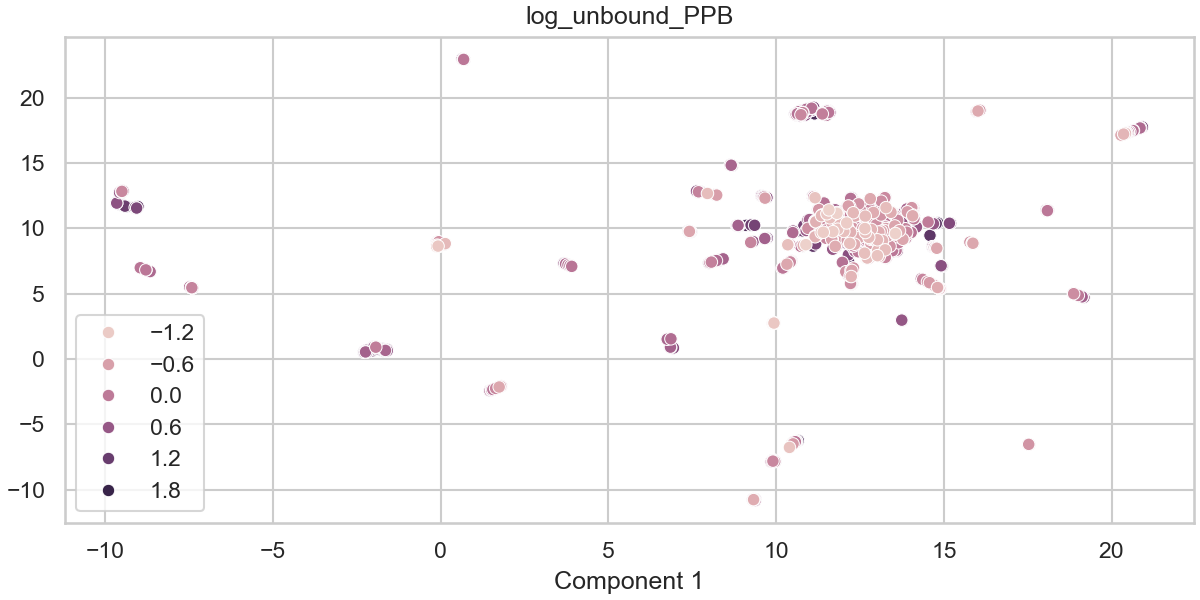

### Re-run curation, removing molecules as needed

In [12]:
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import (
    MoleculeCuration,
    OutlierDetection,
    Deduplication,
    StereoIsomerACDetection,
    ContinuousDistributionVisualization,
)

# Define the curation workflow
curator = Curator(
    data_path=source_data_path,
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols=data_cols),
        ContinuousDistributionVisualization(y_cols=data_cols),
        Deduplication(
            deduplicate_on=mol_col, y_cols=data_cols
        ),  # remove the replicated molecules
        OutlierDetection(
            method="zscore", columns=data_cols, threshold=3, use_modified_zscore=True
        ),
        StereoIsomerACDetection(y_cols=data_cols, threshold=3),
    ],
    parallelized_kwargs={"n_jobs": -1},
)

In [13]:
# The final curation configuration is exported for reproducibility
path = f"{gcp_root}/data/curation/curation_config.json"
curator.to_json(path)

In [14]:
# Run the curation step defined as above
data_curated, report = curator(data)

2024-07-10 01:56:53.200 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-07-10 01:56:58.320 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-07-10 01:56:58.362 | INFO     | auroris.curation._curator:transform:106 - Performing step: deduplicate
2024-07-10 01:56:59.148 | INFO     | auroris.curation._curator:transform:106 - Performing step: outlier_detection
2024-07-10 01:56:59.199 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer


In [15]:
broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-07-10 01:56:53
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 195.
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 2400
===== distribution =====
[IMG]: Dimensions 1200 x 600
===== deduplicate =====
[LOG]: Deduplication merged and removed 0 duplicated molecules from dataset
===== outlier_detection =====
[LOG]: New column added: OUTLIER_log_unbound_PPB
[LOG]:

In [16]:
# Export report to polaris public directory on GCP
# The report is ready to reviewed in the HTML file.
broadcaster = HTMLBroadcaster(
    report, f"{gcp_root}/data/curation/report", embed_images=True
)
broadcaster.broadcast()

'gs://polaris-public/polaris-recipes/org-polaris/astra_zeneca/PPB_clearance/data/curation/report/index.html'

## Export the final curated data

In [17]:
fout = f"{gcp_root}/data/curation/{data_name}_curated.csv"
data_curated.reset_index(drop=True).to_csv(fout, index=False)